In [1]:
!pip install embedding-as-service

In [2]:
import pandas as pd
# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
# sentence feature extracter
from embedding_as_service.text.encode import Encoder
# light model used
import lightgbm as lgb
# metrics for model evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [3]:
url_1 = 'https://raw.githubusercontent.com/TeamEpicProjects/Customer_Support_Ticket_Classification/Day_04/ticket_train.csv'
train = pd.read_csv(url_1)
url_2 = 'https://raw.githubusercontent.com/TeamEpicProjects/Customer_Support_Ticket_Classification/Day_04/ticket_valid.csv'
valid = pd.read_csv(url_2)

In [4]:
glove_en = Encoder(embedding='glove', model='crawl_42B_300')

1142it [00:00, 11415.47it/s]

Loading Model (this might take few minutes).....


1917494it [03:04, 10386.60it/s]

Model loaded Successfully !


In [5]:
# encoding training dataset
glove_train_vecs = glove_en.encode(texts = list(train['info'].values), pooling='reduce_mean')

In [6]:
glove_train_vecs.shape

(38839, 300)

In [7]:
glove_train_vecs

array([[-0.00873258, -0.02062719,  0.00102761, ..., -0.00081924,
         0.01481188,  0.00082802],
       [ 0.00426677, -0.00944219, -0.00951713, ...,  0.01251738,
        -0.0046565 , -0.0145892 ],
       [ 0.01545808, -0.00588574,  0.00529425, ..., -0.01456407,
         0.02462658, -0.01413641],
       ...,
       [-0.00168659, -0.02215202,  0.00156873, ..., -0.00124636,
        -0.01249491, -0.00486416],
       [ 0.00490473, -0.0338532 , -0.00453977, ..., -0.0102833 ,
        -0.01016372, -0.00359499],
       [-0.04608237, -0.13203929,  0.02847104, ..., -0.07718859,
         0.01528471, -0.02900665]])

In [8]:
glove_valid_vecs = glove_en.encode(texts = list(valid['info'].values), pooling='reduce_mean')

In [9]:
glove_valid_vecs.shape

(4855, 300)

In [10]:
clf = lgb.LGBMClassifier(is_unbalance = True) 

In [11]:
clf.fit(glove_train_vecs, train['ticket_type'])

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', is_unbalance=True, learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [12]:
y_valid_preds = clf.predict(glove_valid_vecs)

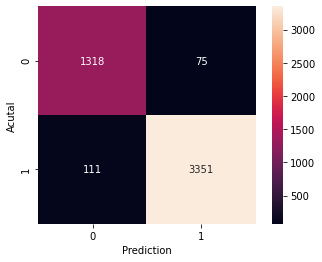

In [13]:
con_mat = confusion_matrix(valid['ticket_type'], y_valid_preds)
sns.heatmap(con_mat, annot=True, fmt='.0f', square=True)
plt.xlabel('Prediction')
plt.ylabel('Acutal')
plt.show()

In [14]:
acc = accuracy_score(valid['ticket_type'], y_valid_preds)
print(f'Model accuracy score = {acc*100:0.2f}%.')

Model accuracy score = 96.17%.


In [15]:
print(classification_report(valid['ticket_type'], y_valid_preds))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93      1393
           1       0.98      0.97      0.97      3462

    accuracy                           0.96      4855
   macro avg       0.95      0.96      0.95      4855
weighted avg       0.96      0.96      0.96      4855



In [16]:
from sklearn.model_selection import RandomizedSearchCV

In [17]:
params_grid = {'n_estimators' : (10,100,10),
        'max_depth' : [None, 3, 5, 10],
        'criterion' : ['gini', 'entropy']}

In [18]:
clf = lgb.LGBMClassifier(is_unbalance = True)

# creating a hyper-tuned model
ht_clf = RandomizedSearchCV(estimator = clf,
                            param_distributions = params_grid,
                            n_iter = 10,
                            cv = 3,
                            verbose = True)

In [19]:
ht_clf.fit(glove_train_vecs, train['ticket_type'])

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.8min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            is_unbalance=True,
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=None, reg_alpha=0.0,
                                            reg_lambda=0.0, silent=True,
                                            subsample=1.0

In [20]:
ht_clf.best_params_

{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 100}

In [21]:
ht_clf.best_score_

0.961430496289497

In [22]:
final_model = lgb.LGBMClassifier(is_unbalance = True,
                                     criterion = 'entropy',
                                     max_depth = None,
                                     n_estimators = 50)

In [23]:
final_model.fit(glove_train_vecs, train['ticket_type'])

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               criterion='entropy', importance_type='split', is_unbalance=True,
               learning_rate=0.1, max_depth=None, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=50,
               n_jobs=-1, num_leaves=31, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [24]:
from google.colab import files
uploaded = files.upload()


Saving ticket_test.csv to ticket_test (1).csv


In [25]:
test = pd.read_csv('/content/ticket_test.csv')

In [26]:
glove_test_vecs = glove_en.encode(texts = list(test['info'].values), pooling='reduce_mean')

In [27]:
y_test_preds = final_model.predict(glove_test_vecs)

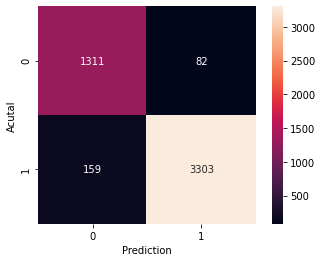

In [28]:
con_mat = confusion_matrix(test['ticket_type'], y_test_preds)
sns.heatmap(con_mat, annot=True, fmt='.0f', square=True)
plt.xlabel('Prediction')
plt.ylabel('Acutal')
plt.show()

In [29]:
acc = accuracy_score(test['ticket_type'], y_test_preds)
print(f'Model accuracy score = {acc*100:0.2f}%.')

Model accuracy score = 95.04%.


In [30]:
print(classification_report(test['ticket_type'], y_test_preds))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      1393
           1       0.98      0.95      0.96      3462

    accuracy                           0.95      4855
   macro avg       0.93      0.95      0.94      4855
weighted avg       0.95      0.95      0.95      4855

